## Django Dataset Exploration Notebook

In [1]:
import nbimporter
from utils_nb import get_all_words_pred

import pickle
import json
import argparse
import code
from pprint import pprint
from termcolor import colored
import re
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple, Counter

import numpy as np
from typing import Dict, Any
from tqdm.auto import tqdm

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

stopWords = set(stopwords.words('english'))

Importing Jupyter notebook from utils_nb.ipynb


In [2]:
code_file = '../../raw-datasets/django/all.code'
anno_file = '../../raw-datasets/django/all.anno'

In [3]:
code_lines = [l.strip() for l in open(code_file, "rt").readlines()]
anno_lines = [l.strip() for l in open(anno_file, "rt").readlines()]

print(len(code_lines))

assert len(code_lines) == len(anno_lines)

example = namedtuple("Example", ["code", "label"])

data = list(map(lambda x : example(*x), zip(code_lines, anno_lines)))

18805


In [4]:
random.shuffle(data)
for i in range(len(data[:1])):
    print(data[i].label)
    print(data[i].code)
    print("---")

remove first element from self.command_stack.
self . command_stack . pop ( )
---


### Vocabulary

In [5]:
PUNCTUATION = {
    'sep'   : u'\u200b' + "/-'´′‘…—−–",
    'keep'  : "&",
    'remove': '?!.,，"#$%\'()*+-/:;<=>@[\\]^_`{|}~“”’™•°'
}

def clean_text(x):
    x = x.lower()

    for p in PUNCTUATION['sep']:
        x = x.replace(p, " ")
    for p in PUNCTUATION['keep']:
        x = x.replace(p, " %s " % p)
    for p in PUNCTUATION['remove']:
        x = x.replace(p, "")

    return x

In [6]:
# random.sample(anno_lines, 1)[0].split()

tokenizer = RegexpTokenizer(r'\w+')

anno_vocab = Counter()

for a in tqdm(anno_lines):
    for w in filter(lambda x : x not in stopWords, tokenizer.tokenize(a)):
        anno_vocab[w.lower()] += 1

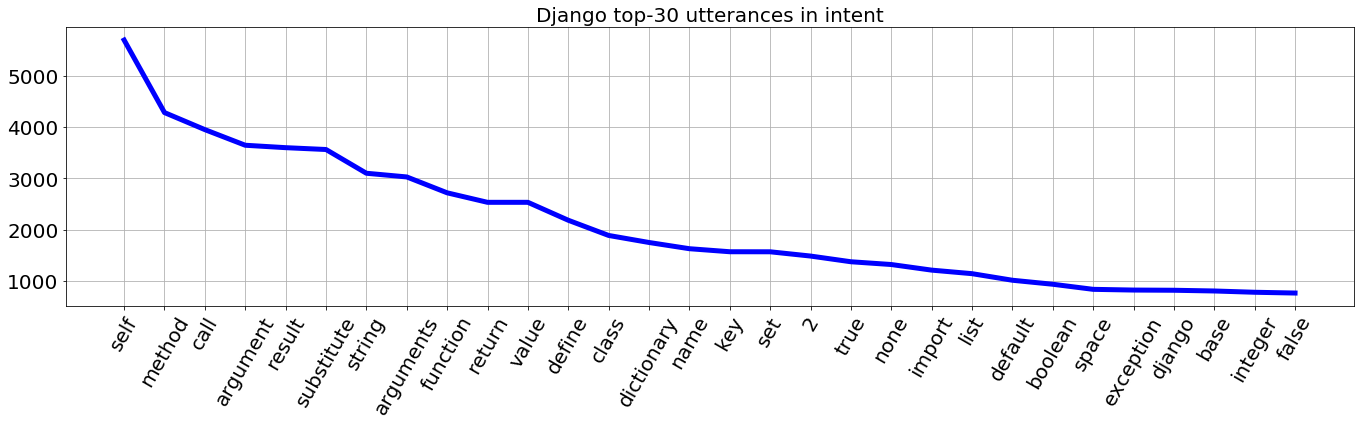

In [7]:
n = 30
words, counts = zip(*anno_vocab.most_common(n))

plt.figure(figsize=(int(0.64 * n),6))
plt.xticks(range(len(words)), words, rotation=60, fontsize=20)
plt.yticks(fontsize=20)
# plt.yscale('symlog')
plt.plot(range(len(words)), counts, 'b-', linewidth=5)
plt.grid()
plt.title('Django top-%d utterances in intent' % n, size=20)
plt.tight_layout()
plt.show()

## Vocabulary coverage

In [8]:
listing = [l.strip() for l in open('../../corpus/python-docs/listing.txt').readlines()]
all_words = Counter()

for l in tqdm(listing, desc="Get all words"):
    file_contents = [clean_text(l.strip().lower()) for l in open(l, "rt").readlines()]
    
    for line in file_contents:
        for w in line.split():
            if re.match(r'[\w]+', w) and w not in stopWords:
                all_words[w] += 1

In [9]:
def get_vocab_coverage(data, vocab) -> (Counter, Counter):
    """
    How much of 'data' is in 'vocab'
    """
    
    oov = Counter() # out-of-vocab
    inv = Counter() # in-vocab
    oov_uniq_num = inv_uniq_num = 0.0
    oov_all_num = inv_all_num = 0.0
    
    for w in tqdm(data):
        if w in vocab:
            inv[w] = data[w]
            inv_uniq_num += 1
            inv_all_num += data[w]
        else:
            oov[w] = data[w]
            oov_uniq_num += 1
            oov_all_num += data[w]
    
    
    assert inv_all_num + oov_all_num == sum(data.values())
    
    cov_uniq = 100.0 * round(inv_uniq_num / len(data), 5)
    cov_all = 100.0 * round(inv_all_num / (inv_all_num + oov_all_num), 5)
    
    print("coverage (unique): %.3f%%" % cov_uniq)
    print("coverage (all text): %.3f%%" % cov_all)
    
    return oov, inv


oov, inv = get_vocab_coverage(anno_vocab, all_words)

'assign' in all_words


coverage (unique): 38.994%
coverage (all text): 85.667%


True

### Check intent-corpus coverage

In [10]:
pt_emb = pickle.load(open('../../embeddings/glove.6B.200d.txt.pickle', 'rb'))

c = get_all_words_pred(
    corpus='../../corpus/python-stackoverflow/question_words_clean.pickle',
    vocab_size=8000,
    word_predicate=lambda w: w in pt_emb,
    min_freq=100, pt_emb=pt_emb
)

In [13]:
# calculate coverage for all words in intents that are also present in embeddings (i.e. skip var names etc)

n = len(anno_vocab)
d = set(anno_vocab.keys()) - set(c.keys())
i = set(anno_vocab.keys()).intersection(set(c.keys()))

x = t = 0
ws = []

for w in anno_vocab:
    if w not in pt_emb: continue
    
    if w in c:
        x += 1
    else:
        ws += [w]
        
    t += 1
    
print("Intent-corpus coverage", round(x/t, 5))

ws[:10]

Intent-corpus coverage 0.79919


['6', 'you', '2', 'e', 'aise', '250', '3', '300', '1', '0']